In [1]:
import torch
from torch.utils.data import DataLoader
from engine.utils import read_config
import engine.datasets as ed
import cv2

# Prepare data

In [2]:
cfg = read_config('configs/config_deblure.yaml')

In [3]:
if cfg.DATASET == 'GoPro_deblure':
    train_dataset = ed.GoPro_deblure(cfg)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=8)

    val_dataset = ed.GoPro_deblure(cfg, 'test')
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, num_workers=8)
    
print('Train dataset length: ', len(train_dataset))
print('Val dataset length: ', len(val_dataset))

Train dataset length:  2103
Val dataset length:  1111


# Prepare net

In [4]:
from engine.model import Model
net = Model(cfg)
print('Number of parameters in net = ', net.get_num_parameters())
net.to(torch.device(net.cfg.DEVICE))

Number of parameters in net =  42883


Model(
  (conv_inp): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sr_block): SR_Block(
    (sender): Sender(
      (conv): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
    )
    (receiver): Receiver(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), dilation=(2, 2))
    )
    (global_pool): AvgPool2d(kernel_size=[200, 200], stride=[200, 200], padding=0)
    (conv1x1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (activation): ReLU()
  )
  (conv_out): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Train

In [5]:
from engine.train import train_val_loop

In [6]:
train_val_loop(net, train_dataloader, val_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: p-k-babkin (p-k-babkin-rsm). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/petr/.netrc


Training epoch [1/5] ...


100%|██████████| 526/526 [01:14<00:00,  7.09it/s]


Epoch [1/5] training finshed, loss =  1.3187487125396729
Validating epoch [1/5] ...


100%|██████████| 1111/1111 [00:48<00:00, 22.86it/s]


Epoch [1/5] validation finshed.
Training epoch [2/5] ...


100%|██████████| 526/526 [01:13<00:00,  7.20it/s]


Epoch [2/5] training finshed, loss =  0.6302579641342163
Validating epoch [2/5] ...


100%|██████████| 1111/1111 [00:48<00:00, 22.84it/s]


Epoch [2/5] validation finshed.
Training epoch [3/5] ...


100%|██████████| 526/526 [01:17<00:00,  6.78it/s]


Epoch [3/5] training finshed, loss =  0.5433223843574524
Validating epoch [3/5] ...


100%|██████████| 1111/1111 [00:51<00:00, 21.59it/s]


Epoch [3/5] validation finshed.
Training epoch [4/5] ...


100%|██████████| 526/526 [01:13<00:00,  7.11it/s]


Epoch [4/5] training finshed, loss =  0.5553091764450073
Validating epoch [4/5] ...


100%|██████████| 1111/1111 [00:49<00:00, 22.34it/s]


Epoch [4/5] validation finshed.
Training epoch [5/5] ...


100%|██████████| 526/526 [01:14<00:00,  7.07it/s]


Epoch [5/5] training finshed, loss =  0.6681462526321411
Validating epoch [5/5] ...


100%|██████████| 1111/1111 [00:48<00:00, 22.73it/s]


Epoch [5/5] validation finshed.


Train/MSE Block 0,█▄▅▂▂▄▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▂▁▂▁▂▂▁▁▂
Train/MSE Block 1,█▄▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁
Train/MSE Block 2,█▅▄▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁
Train/MSE Block 3,█▆▄▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁
Train/MSE Block 4,█▇▄▂▅▃▂▂▂▂▂▂▂▂▁▂▂▂▂▃▁▃▂▁▁▂▁▁▂▂▁▂▁▃▁▁▁▁▁▁
Train/Total Loss,█▆▄▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁
Val/ImMSE Block 0,▇▇▅▇█▇▆▇▅▂▆▄▅▇▅▅▃▅▁▆▆▄▂▂▂▄▅▁▇▅▂▅▁▅▅▂▄▂▄▆
Val/ImMSE Block 1,▆▆▃▇█▇▅█▇▁▇▅▆█▅▅▅▅▁▅▆▆▃▃▃▄▆▁▇▄▃▅▁▅▆▂▅▃▅▆
Val/ImMSE Block 2,▅▅▂▆▇▅▅█▅▁▅▄▅▆▄▄▄▄▁▄▅▅▃▃▄▄▅▃▆▄▄▄▂▅▆▄▅▄▅▅
Val/ImMSE Block 3,▅▅▃▅▆▅▆█▅▁▅▅▅▆▄▄▄▃▁▄▄▄▅▃▃▄▄▅▅▄▄▄▄▅▆▇▆▆▆▆
Val/ImMSE Block 4,▆▆▅▅▇▅▇█▅▁▆▆▆▇▆▆▄▄▃▄▄▄█▄▄▅▅▇▅▆▆▅▇▇▇████▇


# Look at results

In [7]:
from engine.utils import reconstruct_im
import matplotlib.pyplot as plt

In [8]:
sample = train_dataset[12]
test_inp = {
    'im_orig' : torch.tensor(sample['im_orig']).to(torch.float).unsqueeze(0),
    'im_noisy' : torch.tensor(sample['im_noisy']).to(torch.float).unsqueeze(0),
}

net.eval()
net.cpu()
res = net(test_inp)

Text(0.5, 1.0, 'Pred')

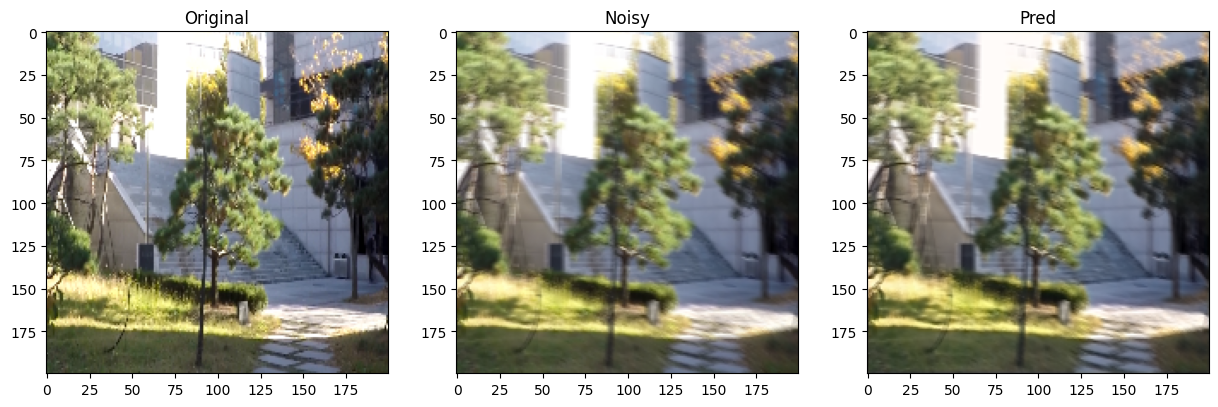

In [9]:
reconstructed_im_orig = reconstruct_im(res['im_orig'][0], cfg)
reconstructed_im_noisy = reconstruct_im(res['im_noisy'][0], cfg)
reconstructed_im_pred = reconstruct_im(res['outputs'][-1][0], cfg)

reconstructed_im_orig = cv2.cvtColor(reconstructed_im_orig, cv2.COLOR_BGR2RGB)
reconstructed_im_noisy = cv2.cvtColor(reconstructed_im_noisy, cv2.COLOR_BGR2RGB)
reconstructed_im_pred = cv2.cvtColor(reconstructed_im_pred, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Рисуем первую картинку
axes[0].imshow(reconstructed_im_orig, cmap='viridis')
axes[0].set_title('Original')

# Рисуем вторую картинку
axes[1].imshow(reconstructed_im_noisy, cmap='viridis')
axes[1].set_title('Noisy')

# Рисуем третью картинку
axes[2].imshow(reconstructed_im_pred, cmap='viridis')
axes[2].set_title('Pred')

In [16]:
import engine.metrics as m
metrics_list = m.create_metrcs_list(cfg)

m.get_metrics_dict(metrics_list, res)

{'ImMSE Block 0': 59.010733333333334,
 'PSNR Block 0': 40.267528714568996,
 'SSIM Block 0': 0.7798980849224811,
 'ImMSE Block 1': 59.215275,
 'PSNR Block 1': 40.24697038630162,
 'SSIM Block 1': 0.7783559205184267,
 'ImMSE Block 2': 59.57940833333333,
 'PSNR Block 2': 40.21281426820909,
 'SSIM Block 2': 0.777216009860528,
 'ImMSE Block 3': 59.83410833333333,
 'PSNR Block 3': 40.19238488292741,
 'SSIM Block 3': 0.7758092645412923,
 'ImMSE Block 4': 60.181558333333335,
 'PSNR Block 4': 40.165220233301994,
 'SSIM Block 4': 0.7740595693071852}

# Wiener filter

Text(0.5, 1.0, 'Pred')

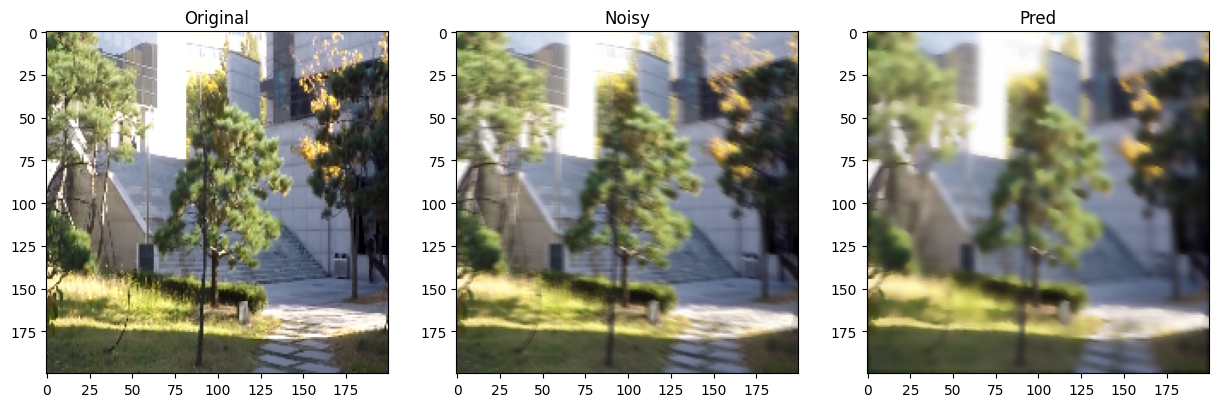

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from skimage import io, color

image = reconstructed_im_noisy / 255

filtered_image = np.zeros_like(image)
for i in range(3):
    filtered_color = wiener(image[:, :, i], (5, 5))
    
    filtered_image[:, :, i] = filtered_color

im_filitered_reconstructed = (filtered_image * 255).astype(np.int32)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Рисуем первую картинку
axes[0].imshow(reconstructed_im_orig, cmap='viridis')
axes[0].set_title('Original')

# Рисуем вторую картинку
axes[1].imshow(reconstructed_im_noisy, cmap='viridis')
axes[1].set_title('Noisy')

# Рисуем третью картинку
axes[2].imshow(im_filitered_reconstructed, cmap='viridis')
axes[2].set_title('Pred')

In [18]:
import engine.metrics as m

metrcs_list = m.create_metrcs_list(cfg)

metrics_dict = {}


for metric in metrcs_list:
    metrics_dict[f'Wiener filter, {metric.name}' ] = metric.calculate(im_filitered_reconstructed, reconstructed_im_orig)

metrics_dict

{'Wiener filter, ImMSE': 447.04470833333335,
 'Wiener filter, PSNR': 36.51418186334561,
 'Wiener filter, SSIM': 0.6293044165329067}